## Introduction

In some cases you know the state of the transformer, e.g. because you have hotspot and topoil temperature measurement and want to make a prediction for the remainder period, then you can use this to initiate transformer. 

If you do not initiate with this information you should be aware that the the model is, by default, initiated with the ambient temperature and therefore requires a warm-up period. For a power transformer both top-oil and hot-spot temperature are initiated with the ambient temperature plus the ambient temperature surcharge. In case of a distribution transformer both are initiated with the ambient temperature. As a consequence, a period should be cut off. Typically a period of 5 times the oil time constant in minutes is used: `my_transformer.specs.time_const_oil * 5`. In this period the transformer had enough time to warm up or cool down to match the applied load and ambient temperature.

In the other examples a period is manually truncated from the resulting temperature profiles. In these examples this is required because this part of the result is not reliable.

In this example the model is initiated with an initial state and a constant load and ambient temperature profile are used. 
The result is then compared with a result without providing an initial state.


Before we start modelling the transformer, we will first import all the required functions and classes.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from transformer_thermal_model.cooler import CoolerType
from transformer_thermal_model.model import Model
from transformer_thermal_model.schemas import InputProfile, UserTransformerSpecifications
from transformer_thermal_model.transformer import PowerTransformer

## Load and ambient temperature profile
First we will create data to simulate the ambient temperature during this summer week together with a constant load.
Both profiles will have a duration of a week with a sampling time of 15 minutes. 


In [2]:
one_week = 4 * 24 * 7
datetime_index = pd.date_range("2025-07-01", periods=one_week, freq="15min")

# The ambient temperature during this week is 20 degrees celsius
ambient_temp = 20
ambient_series = pd.Series([ambient_temp] * one_week, index=datetime_index)

# And the transformer is exposed to a nominal load of 100 Ampere:
load = 100
load_series = pd.Series([load] * one_week, index=datetime_index)

# Create an input object with the profiles
profile_input = InputProfile.create(
    datetime_index=datetime_index, load_profile=load_series, ambient_temperature_profile=ambient_series
)

## Transformer creation
The next step is to create a power transformer object. We will use the default specifications of the power transformer. Additionally, there are five mandatory specifications to be set.

_Note that the specification in the example below are randomly chosen._

In [3]:
transformer_specifications = UserTransformerSpecifications(
    load_loss=1000,  # Transformer load loss [W]
    nom_load_sec_side=1500,  # Transformer nominal current secondary side [A]
    no_load_loss=200,  # Transformer no-load loss [W]
    amb_temp_surcharge=20,  # Ambient temperature surcharge [K]
)
cooler_type = CoolerType.ONAN
transformer = PowerTransformer(user_specs=transformer_specifications, cooling_type=cooler_type)

## Modelling without and with manual initialization
Now it is time to create a model based on the transformer and the profiles and run the model to create a temperature profile of the top-oil and the hot-spot.

Below we create two models: one *with* initialization and one *without* initialization.

In [4]:
model_without_initialization = Model(
    temperature_profile=profile_input,
    transformer=transformer,
)

results_without_initialization = model_without_initialization.run()

In [ ]:
model_with_initialization = Model(
    temperature_profile=profile_input,
    transformer=transformer,
    init_top_oil_temp=54.5,
)

results_with_initialization = model_with_initialization.run()

If you look at the results, you can see that the model *with* initialization already has the correct start temperature and the trunctation of the start period is not required. 

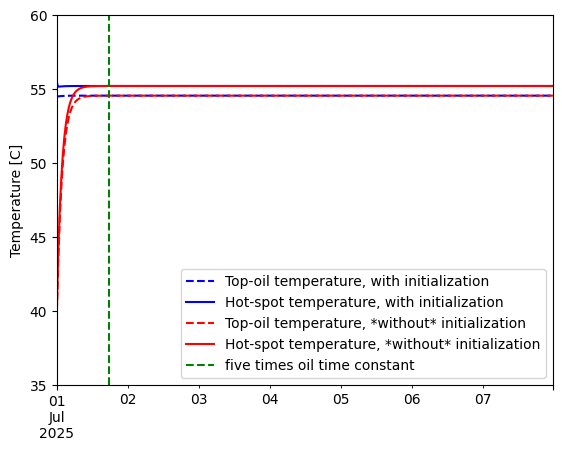

In [6]:
truncation_time = datetime_index[0] + pd.Timedelta(transformer.specs.time_const_oil * 5, "m")

fig = plt.figure()
ax = results_with_initialization.top_oil_temp_profile.plot(
    label="Top-oil temperature, with initialization", color="blue", style="--"
)
results_with_initialization.hot_spot_temp_profile.plot(
    label="Hot-spot temperature, with initialization", color="blue", style="-"
)

results_without_initialization.top_oil_temp_profile.plot(
    label="Top-oil temperature, *without* initialization", color="red", style="--"
)
results_without_initialization.hot_spot_temp_profile.plot(
    label="Hot-spot temperature, *without* initialization", color="red", style="-"
)

ax.vlines(truncation_time, 35, 60, linestyles="dashed", label="five times oil time constant", color="green")
# ambient_series.plot(label='Ambient temperature')
ax.set_ylabel("Temperature [C]")
ax.set_xlim([datetime_index[0], datetime_index[-1]])
ax.set_ylim([35, 60])
ax.legend(loc="lower right");

In [7]:
print(results_without_initialization.top_oil_temp_profile.head(1))
print(results_without_initialization.hot_spot_temp_profile.head(1))

2025-07-01    40.0
dtype: float64
2025-07-01    40.0
dtype: float64


If we zoom in into the first period we can see that, indeed, within the period of five times the oil time-constant the model without initialization did converge.
 

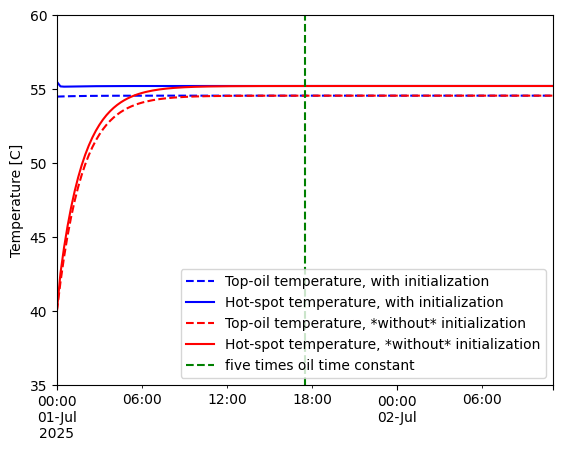

In [8]:
x_lim = datetime_index[0] + pd.Timedelta(transformer.specs.time_const_oil * 10, "m")
fig = plt.figure()
ax = results_with_initialization.top_oil_temp_profile.plot(
    label="Top-oil temperature, with initialization", color="blue", style="--"
)
results_with_initialization.hot_spot_temp_profile.plot(
    label="Hot-spot temperature, with initialization", color="blue", style="-"
)

results_without_initialization.top_oil_temp_profile.plot(
    label="Top-oil temperature, *without* initialization", color="red", style="--"
)
results_without_initialization.hot_spot_temp_profile.plot(
    label="Hot-spot temperature, *without* initialization", color="red", style="-"
)

ax.vlines(truncation_time, 35, 60, linestyles="dashed", label="five times oil time constant", color="green")
# ambient_series.plot(label='Ambient temperature')
ax.set_ylabel("Temperature [C]")
ax.set_xlim([datetime_index[0], x_lim])
ax.set_ylim([35, 60])
ax.legend(loc="lower right");